In [1]:
import pandas as pd
import numpy as np
import networkx as nx
import random
from scipy.stats import pearsonr
from scipy.spatial import distance
import seaborn as sns
%matplotlib inline
import matplotlib.pyplot as plt
plt.rcParams['figure.figsize']=20,20

pd.set_option('display.max_rows', 6000)
pd.set_option('display.max_columns', 100)
pd.set_option('display.width', 1000)

The history saving thread hit an unexpected error (DatabaseError('database disk image is malformed',)).History will not be written to the database.


Carrega a base de média diária de voos

In [2]:
international_flights_avg = pd.read_csv('jan-media_voos.csv')
international_flights_avg = international_flights_avg[['org', 'dest', 'valor_norm']]
international_flights_avg = international_flights_avg.rename(columns={'org': 'source', 'dest': 'target', 'valor_norm':'value'})

In [3]:
international_flights_avg.head()

,source,target,value
0,Algeria,Austria,1.000000
1,Algeria,Belgium,1.275510
2,Algeria,Canada,1.000000
3,Algeria,France,12.272727
4,Algeria,Germany,1.560345


Constrói o grafo com a probabilidade de voos entre países

In [4]:
country_international_flights = international_flights_avg.groupby(['source']).sum() 
transition_matrix = international_flights_avg.copy()

transition_matrix = transition_matrix.set_index('source').join(country_international_flights, lsuffix='_daily_flights', rsuffix='_source_sum_flights')

transition_matrix['prob'] = (transition_matrix['value_daily_flights']/transition_matrix['value_source_sum_flights'])
transition_matrix = transition_matrix.drop(columns=['value_source_sum_flights', 'value_daily_flights']).reset_index()

In [5]:
transition_matrix.head()

,source,target,prob
0,Algeria,Austria,0.027296
1,Algeria,Belgium,0.034816
2,Algeria,Canada,0.027296
3,Algeria,France,0.334996
4,Algeria,Germany,0.042591


transition_matrix_crosstab = pd.crosstab(transition_matrix['target'], transition_matrix['source'], transition_matrix['prob'], aggfunc=sum)
transition_matrix_crosstab = transition_matrix_crosstab.fillna(0)

transition_matrix_crosstab

Carrega o arquivo com o total diário de casos e pega o dia específico - 77

In [6]:
total_cases = pd.read_csv('total_cases_countries_normalized.csv')
total_cases = total_cases[['Name', 'Day', 'Total']].set_index(['Name', 'Day'])

daily_cases = total_cases.xs(77, level=1).reindex(transition_matrix['source'].unique())

daily_cases = daily_cases.rename(columns={'Total': 'n_cases'}) 

In [7]:
daily_cases.isna()

n_cases    6
dtype: int64

In [8]:
daily_cases = daily_cases.fillna(0)
daily_cases

,n_cases
Name,
Algeria,58.0
Argentina,65.0
Armenia,52.0
Australia,375.0
Austria,1016.0
Bahrain,221.0
Bangladesh,5.0
Barbados,0.0
Belarus,36.0


In [9]:
#TODO: os nomes das df de voos e  casos parecem estar muito diferentes. eh preciso normaliza-los... veja que tem muito valor nulo no votor abaixo 

state_df_start = total_cases.xs(0, level=1).reindex(transition_matrix['source'].unique())
state_df_start = state_df_start.fillna(0)

state_df_start

,Total
Name,
Algeria,0.0
Argentina,0.0
Armenia,0.0
Australia,0.0
Austria,0.0
Bahrain,0.0
Bangladesh,0.0
Barbados,0.0
Belarus,0.0


Faz o random walk

In [10]:
transition_matrix_crosstab = pd.crosstab(transition_matrix['target'], transition_matrix['source'], transition_matrix['prob'], aggfunc=sum)
transition_matrix_crosstab = transition_matrix_crosstab.fillna(0)

In [11]:
transition_matrix = transition_matrix.set_index(['source', 'target'])

In [12]:
def transition_matrix_loss(loss_df):    
    df_joined = transition_matrix.join(loss_df, how='left')

    df_joined['prob'] = df_joined['prob'] - df_joined['prob']*df_joined['pct_loss']

    df_joined = df_joined.reset_index()

    df_joined = pd.crosstab(df_joined['target'], df_joined['source'], df_joined['prob'], aggfunc=sum)
    df_joined = df_joined.fillna(0)

    return df_joined

In [14]:
week_loss_df = pd.read_csv('data/week_pct_loss.csv').drop(columns=['Unnamed: 0']).rename(columns={'org': 'source', 'dest':'target'})

Cria o dataframe a ser utilizado e roda o gridsearch

In [15]:
contamination_rate = np.arange(1.01,1.5,0.02)
travel_rate = np.arange(0.0000001,0.00005,0.000002)

initial_number = [x for x in range(1500,2510,50)] 
correlation_df = pd.DataFrame(columns=['V', 'R', 'Euclidean Distance'])

def model_spread2(r, p):
    state_df = state_df_start #new_state_df(v, transition_matrix_crosstab)
#     state_df = transition_matrix_crosstab.dot(state_df)
    for i in range(1, 78):
        week = i/7
        if(week<5):
            state_df = state_df*r + (transition_matrix_crosstab.dot(state_df)*p)
        else:
            week_loss = week_loss_df.set_index(['week_value']).loc[week].reset_index().set_index(['source', 'target']).drop(columns=['week_value'])
            transition_matrix_week =transition_matrix_loss(week_loss)
            state_df = state_df*r + (transition_matrix_week.dot(state_df)*p)
            
    return state_df

v_min_dist = initial_number[0]
r_min_dist = contamination_rate[0]
p_min_dist = travel_rate[0]
min_dist = np.Inf

# p = 0.01

for p in travel_rate:
    for r in contamination_rate: 
        state_df = model_spread2(r, p)
                
        dist_euclidean = distance.euclidean(daily_cases, state_df)
        
        df = pd.DataFrame([{'P': p, 'R': r, 'Euclidean Distance': dist_euclidean}])
        correlation_df = correlation_df.append(df, ignore_index=True)
            
        if abs(dist_euclidean)<abs(min_dist):
            min_dist = dist_euclidean
            r_min_dist = r
            p_min_dist = p
        
print('Menor distancia Euclideana: ' + str(min_dist))
print('P: ' + str(p_min_dist))
print('R: ' + str(r_min_dist))

/home/paulagiov/.local/lib/python2.7/site-packages/pandas/core/frame.py:6692: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  sort=sort)


Menor distancia Euclideana: 34234.8004507
P: 4.8100000000000004e-05
R: 1.11


In [16]:
state_df_final = model_spread2(r_min_dist, p)

print(state_df_final.sum())

state_df_final.sort_values('Total', ascending=False)

Total    83582.33558
dtype: float64


,Total
Name,
China,83412.885820
Thailand,14.627126
South Korea,12.534703
Malaysia,11.183463
Taiwan,10.308257
Japan,9.279497
Singapore,8.418735
United States,6.311605
Philippines,5.632199


In [17]:
print(daily_cases.sum())

daily_cases.sort_values('n_cases', ascending=False)

n_cases    166950.0
dtype: float64


,n_cases
Name,
China,81063.0
Italy,27980.0
Spain,13994.0
South Korea,8320.0
France,6633.0
Germany,6012.0
United States,4661.0
Switzerland,2200.0
United Kingdom,1543.0


In [18]:
pearsonr(state_df_final.T.values[0], daily_cases.T.values[0])

(0.9249274008331257, 1.0720433807091121e-30)

In [243]:
#daily_cases.rename_axis("source").index

In [19]:
#TODO: daily_cases tem tuplas como indice. ajustar la em cima para que o indice seja simplesmente o nome do pais (nao fazendo essa gambiarra que fiz mas sim usando o pandas do jeito certo para que isto nao aconteca)

#daily_cases.index = [x[0] for x in daily_cases.rename_axis("source").index]

daily_cases['n_cases'] = daily_cases['n_cases'].astype(float)

daily_cases

,n_cases
Name,
Algeria,58.0
Argentina,65.0
Armenia,52.0
Australia,375.0
Austria,1016.0
Bahrain,221.0
Bangladesh,5.0
Barbados,0.0
Belarus,36.0


In [20]:
state_df_final.join(daily_cases).corr()

,Total,n_cases
Total,1.000000,0.924927
n_cases,0.924927,1.000000


In [21]:
correlation_pivot = correlation_df.pivot(index='P', columns='R', values='Euclidean Distance')
correlation_pivot

R,1.01,1.03,1.05,1.07,1.09,1.11,1.13,1.15,1.17,1.19,1.21,1.23,1.25,1.27,1.29,1.31,1.33,1.35,1.37,1.39,1.41,1.43,1.45,1.47,1.49
P,,,,,,,,,,,,,,,,,,,,,,,,,
1.000000e-07,87914.981823,87726.284860,86904.459401,83436.411020,69475.350995,34245.717339,251187.699391,1.193215e+06,4.723858e+06,1.763963e+07,6.386846e+07,2.258924e+08,7.823296e+08,2.656055e+09,8.846418e+09,2.892360e+10,9.288375e+10,2.931324e+11,9.095936e+11,2.776536e+12,8.341333e+12,2.467395e+13,7.189521e+13,2.064422e+14,5.843949e+14
2.100000e-06,87914.981687,87726.284258,86904.456778,83436.399557,69475.294751,34245.262976,251187.458792,1.193215e+06,4.723858e+06,1.763963e+07,6.386846e+07,2.258924e+08,7.823296e+08,2.656055e+09,8.846418e+09,2.892360e+10,9.288375e+10,2.931324e+11,9.095936e+11,2.776536e+12,8.341333e+12,2.467395e+13,7.189521e+13,2.064422e+14,5.843949e+14
4.100000e-06,87914.981552,87726.283655,86904.454153,83436.388090,69475.238494,34244.808569,251187.218303,1.193215e+06,4.723858e+06,1.763963e+07,6.386846e+07,2.258924e+08,7.823296e+08,2.656055e+09,8.846418e+09,2.892360e+10,9.288375e+10,2.931324e+11,9.095936e+11,2.776536e+12,8.341333e+12,2.467395e+13,7.189521e+13,2.064422e+14,5.843949e+14
6.100000e-06,87914.981416,87726.283052,86904.451529,83436.376620,69475.182223,34244.354117,251186.977924,1.193215e+06,4.723858e+06,1.763963e+07,6.386846e+07,2.258924e+08,7.823296e+08,2.656055e+09,8.846418e+09,2.892360e+10,9.288375e+10,2.931324e+11,9.095936e+11,2.776536e+12,8.341333e+12,2.467395e+13,7.189521e+13,2.064422e+14,5.843949e+14
8.100000e-06,87914.981281,87726.282449,86904.448903,83436.365148,69475.125941,34243.899622,251186.737656,1.193214e+06,4.723858e+06,1.763963e+07,6.386846e+07,2.258924e+08,7.823296e+08,2.656055e+09,8.846418e+09,2.892360e+10,9.288375e+10,2.931324e+11,9.095936e+11,2.776536e+12,8.341333e+12,2.467395e+13,7.189521e+13,2.064422e+14,5.843949e+14
1.010000e-05,87914.981145,87726.281846,86904.446277,83436.353672,69475.069645,34243.445082,251186.497497,1.193214e+06,4.723857e+06,1.763963e+07,6.386846e+07,2.258924e+08,7.823296e+08,2.656055e+09,8.846418e+09,2.892360e+10,9.288375e+10,2.931324e+11,9.095936e+11,2.776536e+12,8.341333e+12,2.467395e+13,7.189521e+13,2.064422e+14,5.843949e+14
1.210000e-05,87914.981009,87726.281242,86904.443650,83436.342193,69475.013336,34242.990498,251186.257450,1.193214e+06,4.723857e+06,1.763962e+07,6.386846e+07,2.258924e+08,7.823296e+08,2.656055e+09,8.846418e+09,2.892360e+10,9.288375e+10,2.931324e+11,9.095936e+11,2.776536e+12,8.341333e+12,2.467395e+13,7.189521e+13,2.064422e+14,5.843949e+14
1.410000e-05,87914.980874,87726.280639,86904.441022,83436.330711,69474.957014,34242.535870,251186.017512,1.193214e+06,4.723857e+06,1.763962e+07,6.386846e+07,2.258924e+08,7.823296e+08,2.656055e+09,8.846419e+09,2.892360e+10,9.288375e+10,2.931324e+11,9.095936e+11,2.776536e+12,8.341333e+12,2.467395e+13,7.189521e+13,2.064422e+14,5.843949e+14
1.610000e-05,87914.980738,87726.280035,86904.438393,83436.319226,69474.900680,34242.081198,251185.777685,1.193214e+06,4.723857e+06,1.763962e+07,6.386846e+07,2.258924e+08,7.823296e+08,2.656055e+09,8.846419e+09,2.892360e+10,9.288375e+10,2.931324e+11,9.095936e+11,2.776536e+12,8.341333e+12,2.467395e+13,7.189521e+13,2.064422e+14,5.843949e+14


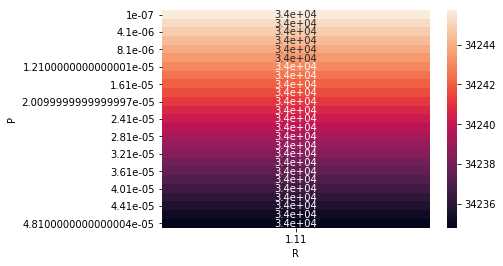

In [23]:
heatmap = sns.heatmap(correlation_pivot.iloc[:,5:6], annot=True)